# EEG Preprocessing using independent component analysis (ICA)
ICA can be used for artefact detection, since it identifies seperate components of the signal that have been combined during recording. That means that we can actually separate noise compoenents, such as eye blinks, from the rest of the signal, and thereby exclude them.


**Links:** https://arnauddelorme.com/ica_for_dummies/


## Loading modules & data

In [5]:
# importing modules
import numpy as np
import mne
import pandas as pd
import helper_functions as hf
import matplotlib.pyplot as plt
#! pip install mne
#! pip install scikit-learn

In [6]:
raw = mne.io.read_raw_brainvision('Stroop_mouse_EEG_data/EEG/Group7_own.vhdr', eog=('EOG1', 'EOG2'), preload = True)

Extracting parameters from Stroop_mouse_EEG_data/EEG/Group7_own.vhdr...
Setting channel info structure...
Reading 0 ... 487319  =      0.000 ...   487.319 secs...


### Removing EEG data which was recorded before and after the experiment

In [7]:
raw.crop(tmin=0.0, tmax=410, include_tmax=True)

<RawBrainVision | Group7_own.eeg, 32 x 410001 (410.0 s), ~100.1 MB, data loaded>

### Specifing the channel locations using the montage-related functions

In [8]:
montage = mne.channels.make_standard_montage('standard_1020') 
raw.set_montage(montage, verbose=False)

<RawBrainVision | Group7_own.eeg, 32 x 410001 (410.0 s), ~100.1 MB, data loaded>

## Redefine the reference to a common average

In [9]:
raw.set_eeg_reference('average', projection=False, verbose=False)

<RawBrainVision | Group7_own.eeg, 32 x 410001 (410.0 s), ~100.1 MB, data loaded>

## Preparing data for ICA
High-pass filtering the data at 0.1 Hz and subsequently low-pass filtering at 40 Hz

In [10]:
# removing two noisy channels
raw.info['bads'] = ['Fp1', 'Fp2']

In [11]:
filt_raw = raw.copy().filter(l_freq=1., h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 sec)



## Setting up and fitting the ICA
Fitting the ICA with 800 iterations with a random seed at 97. n_components=0.95 ensures that the number of components selected explain at least 95% of the variance in the data

In [12]:
ica = mne.preprocessing.ICA(n_components=0.95, random_state=97, max_iter=800)
ica.fit(filt_raw)

Fitting ICA to data using 28 channels (please be patient, this may take a while)
Selecting by explained variance: 13 components
Fitting ICA took 5.2s.


Method,fastica
Fit,31 iterations on raw data (410001 samples)
ICA components,13
Explained variance,95.2 %
Available PCA components,28
Channel types,eeg
ICA components marked for exclusion,—


## Plotting of ICA
### Plotting of components

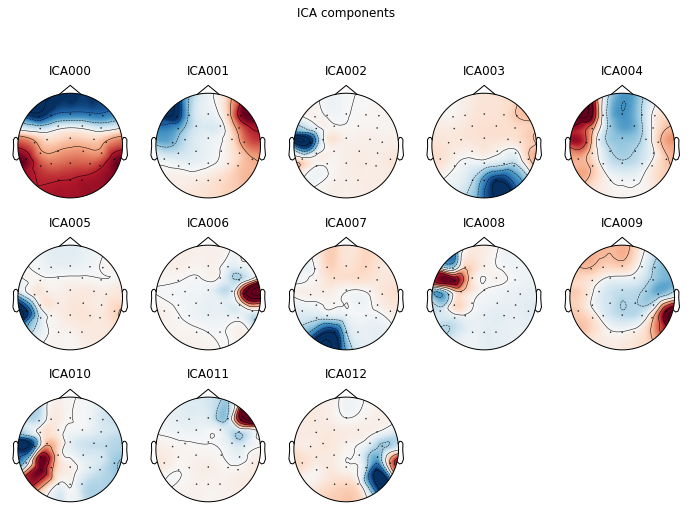

In [13]:
ica.plot_components();

### Plotting of the time series of the ICA components that are assumed to be noise

Creating RawArray with float64 data, n_channels=4, n_times=410001
    Range : 0 ... 410000 =      0.000 ...   410.000 secs
Ready.
Using matplotlib as 2D backend.


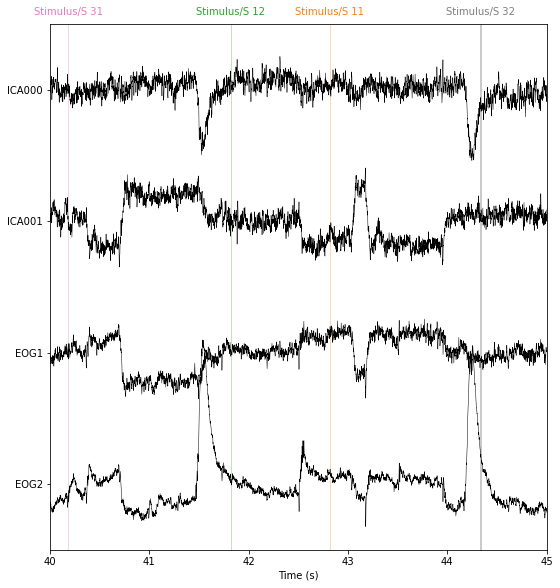

In [14]:
ica.plot_sources(raw, picks = [0,1], show_scrollbars=False, start = 40, stop = 45);


## Exclusion of components
The blinks can be seen very clearly in ICA001, especially in the time series plot. Therefore this component is removed. 
Furthermore, ICA000 seems to capture the effects of eye-movement.  In the time series plot, you can see evidence of saccades by the discontinuities surrounded by relative stationarity. This is reinforced by the scalp topography plot, as they indicate that the source origin is near the eyes.


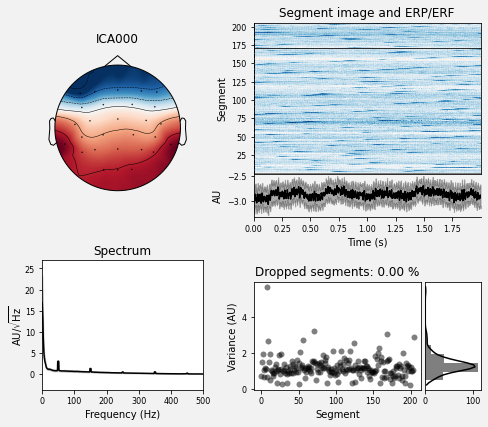

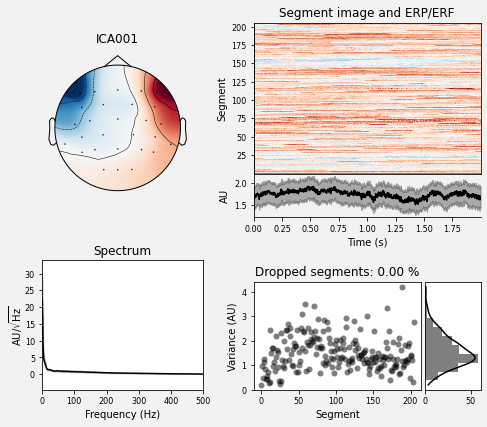

[<Figure size 504x432 with 6 Axes>, <Figure size 504x432 with 6 Axes>]

In [15]:
ica.exclude = [0,1]
ica.plot_properties(raw, picks=ica.exclude, dB = False, verbose = False)

## Applying ICA to the data

In [16]:
ica.apply(raw)

# High and low pass filtering after applying the ICA
raw = raw.filter(0.1, None)
raw = raw.filter(None, 40)

Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 2 ICA components
    Projecting back using 28 PCA components
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff f

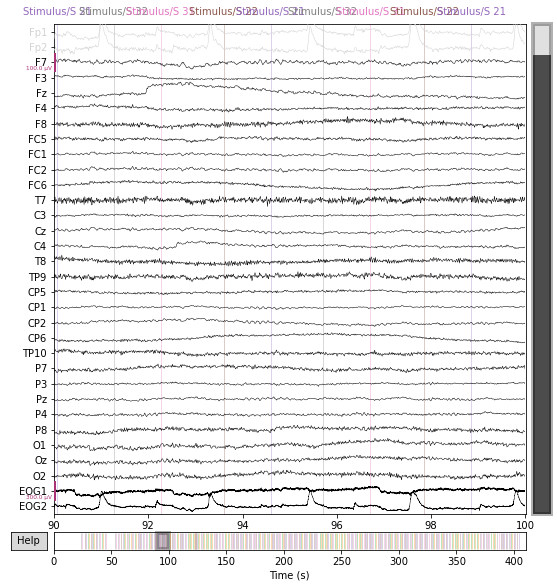

In [17]:
# plotting the data after ICA
raw.plot(n_channels = 33, scalings = {'eeg': 50e-6}, duration = 10, start = 90);

### Epoching the data
Using the `events_from_annotations` function an array of the events is extracted. The first column is the time stamp in samples, and the third column contains the event id.

In [18]:
events, _  = mne.events_from_annotations(raw)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 31', 'Stimulus/S 32']


#### Deleting triggers from practise trials and incorrect trials

Incorrect trials: 22, 48, 86, 145, 153 (to get the indexes we take the incorrect trial and add 9 and then take that and multiply by 2)


In [19]:
incorrect_trials = [22, 48, 86, 145, 153] 
incorrectinds = [(i*2+17) for i in incorrect_trials]

incorrectinds.extend([i +1 for i in incorrectinds])

practisetrials = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [20]:
remove =  practisetrials + incorrectinds

In [21]:
events = np.delete(events, remove, 0)

#### Adding events
This is done by importing some data extracted from the mousetracking data in R using the `mousetrap` package. 


TODO:
* **Find out which variable** does not seem to be the right one at least

In [22]:
# Loading in csv with info
mouse_df_inc = pd.read_csv('Stroop_mouse_EEG_data/additional_triggers_incongruent.csv')
mouse_df_neu = pd.read_csv('Stroop_mouse_EEG_data/additional_triggers_neutral.csv')
mouse_df_con = pd.read_csv('Stroop_mouse_EEG_data/additional_triggers_congruent.csv')

##### Aligning timing from behavioural data with EEG


In [23]:
# Determining timing for display of first image in EEG (measured in samples)
sample_time_first_image = events[1][0]          # one since first trigger is when the recording started

# Sampling rate
sampling_rate_eeg = 1000/1                      # 1000 Hz

# Timing for display of first images in mousetracking (measured in seconds, first trial is in the incongruent dataframe)
mouse_first_img_display = mouse_df_inc.iloc[0,3]

# Adding trigger for max MAD in incongruent condition
events = hf.add_trigger(mouse_df_inc, 
                        trigger = 33,
                        array = events, 
                        first_img_display = mouse_first_img_display, 
                        sr_eeg = sampling_rate_eeg, 
                        st_first_image = sample_time_first_image, 
                        columnname = 'MAD_time')

Now an array is created with these additional triggers

In [24]:
# Determining all the unique triggers
np.unique(events[:,2])

array([   11,    12,    21,    22,    31,    32,    33, 99999])

In [25]:
# Creating a dictionary with event ids
event_id = {'Image/cNeu': 11, # Image trigger neutral condition 
            'Image/cCon': 21, # Image trigger congruent condition  
            'Image/cInc': 31, # Image trigger incongruent condition 
            'Word/cNeu': 12, # Word trigger neutral condition
            'Word/cCon': 22, # Word trigger congruent condition
            'Word/cInc': 32, # Word trigger incongruent condition
            'Max_MAD/cInc': 33 # Word trigger incongruent conditionn
} 

/var/folders/4t/gp67d4t56ysgr041byyd6shr0000gn/T/ipykernel_14751/3511924737.py:1: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(events, first_samp=raw.first_samp, event_id=event_id);


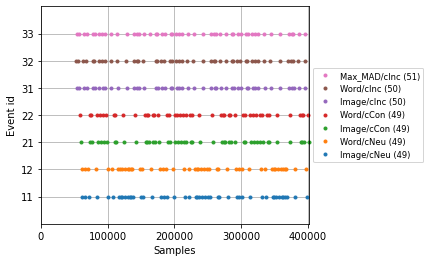

In [26]:
mne.viz.plot_events(events, first_samp=raw.first_samp, event_id=event_id);

**Note:** Determine sensible time window

In [27]:
# establishing time window
tmin, tmax = -0.2, 0.5

In [28]:
# rejecting all epochs with values exeeding 150 micro volts - cannot be brain data
reject = {'eeg': 150e-6}

In [29]:
# choosing only EEG channels for epoching
picks = mne.pick_types(raw.info, eeg=True, eog=False)

In [30]:
# creating the epochs using the variables created in the cell above, and timelocking to the events
# baseline time interval spans from beginning of the data (-0.2 s) to 0 s (stimulus onset)
# we use the reject variable we created earlier in order to remove artefacts
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks, baseline=(None, 0), reject=reject, preload=True, verbose = False)


# Downsampling to 250 Hz
epochs = epochs.resample(250)
epochs.save("Stroop_mouse_EEG_data/epochs/epochs_epo.fif", overwrite=True)


/var/folders/4t/gp67d4t56ysgr041byyd6shr0000gn/T/ipykernel_14751/1333701081.py:4: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks, baseline=(None, 0), reject=reject, preload=True, verbose = False)


Overwriting existing file.


### Plotting sorted by RT
In order to plot the epochs sorted by reaction time, we need to provide the `plot_epochs_image` function with the overlay time and order. 


#### Overlay time and order

**Overlay time:**
Times (in seconds) at which to draw a line on the corresponding row of the image (e.g., a reaction time associated with each epoch). Note that overlay_times should be ordered to correspond with the Epochs object (i.e., overlay_times[0] corresponds to epochs[0], etc).

**Order_**
Order is used to reorder the epochs along the y-axis of the image. If it is an array of int, its length should match the number of good epochs. If it is a callable it should accept two positional parameters (times and data, where data.shape == (len(good_epochs), len(times))) and return an array of indices that will sort data along its first axis.

In [31]:
# reading in data frame with reaction times
data_mouse = pd.read_csv('Stroop_mouse_EEG_data/behavioural/trial_info.csv')

# extracting reation times
overlay_times_mouse = data_mouse['rt']

# gettting the order (argsort returns the indicies which sorts the data)
order = np.argsort(overlay_times_mouse)

#### Epoching the data

In [32]:
# getting events
events1, _  = mne.events_from_annotations(raw)

# deleting the 18 first events which are practise trials
events1 = np.delete(events1, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], 0)


# for loop to delete events that are not images being shown (wordtriggers, and triggers that starts the experiment)
delete_index = []

# looping over the events
for i in range(len(events1)):
    trigger = events1[i][2]

    if trigger in [12, 22, 32, 99999]:
        # appending the index to the delete_index list
        delete_index.append(i)


# delete the events not wanted
events1 = np.delete(events1, delete_index, axis=0)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 31', 'Stimulus/S 32']


In [33]:
# dictionary containing information of the events
event_id1 = {'Image/cNeu': 11, # Image trigger neutral condition 
            'Image/cCon': 21, # Image trigger congruent condition  
            'Image/cInc': 31  # Image trigger incongruent condition 
}

# tmin and tmax
tmin_rt, tmax_rt = -0.2, 1.75

# choosing only EEG channels for epoching
picks1 = mne.pick_types(raw.info, eeg=True, eog=False)

# creating epocks
epochs_rt = mne.Epochs(raw, events1, event_id1, tmin_rt, tmax_rt, picks = picks1, baseline=(None, 0), reject=None, preload=True, verbose = True)
epochs_rt = epochs_rt.resample(250)

Not setting metadata
Not setting metadata
153 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 153 events and 1951 original time points ...
0 bad epochs dropped


#### Plotting

Not setting metadata
Not setting metadata
153 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


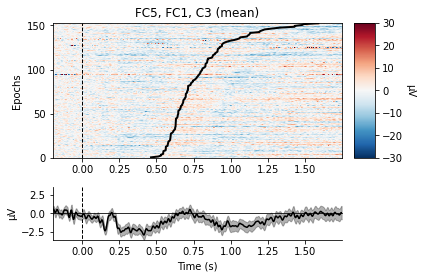

[<Figure size 432x288 with 3 Axes>]

In [35]:
#plt_times = np.linspace(0, .2, len(epochs_rt))
#plt.close('all')

# Plotting the 11 channels found in cluster-based permutation test
#mne.viz.plot_epochs_image(epochs_rt, order=order, overlay_times=overlay_times_mouse, group_by={'11 channels from clusterbased permutation test': [1, 5, 6, 7, 10, 11, 12, 16, 17, 21, 22]}, combine = 'mean')

# Plotting select channels
mne.viz.plot_epochs_image(epochs_rt, order=order, overlay_times=overlay_times_mouse, group_by={'FC5, FC1, C3' : [5, 6, 10]}, combine = 'mean', vmin = -30, vmax = 30)

## Epoching with RT

In [29]:
# reading in data frame with reaction times
data_mouse = pd.read_csv('Stroop_mouse_EEG_data/behavioural/trial_info.csv')
rt = data_mouse['rt']

# Sampling rate
sampling_rate_eeg = 1000/1                      # 1000 Hz


# getting events
events, _  = mne.events_from_annotations(raw)

# deleting the 18 first events which are practise trials
events = np.delete(events, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], 0)


# for loop to delete events that are not images being shown (wordtriggers, and triggers that starts the experiment)
delete_index = []

# looping over the events
for i in range(len(events)):
    trigger = events[i][2]

    if trigger in [12, 22, 32, 99999]:
        # appending the index to the delete_index list
        delete_index.append(i)


# delete the events not wanted
events = np.delete(events, delete_index, axis=0)

for i in range(len(events)):
    sample_time_img_trigger = events[i][0]
    additional_samples = rt[i] * sampling_rate_eeg

    events[i][0] = sample_time_img_trigger + additional_samples


# removing incorrect trials as well
incorrect_ind = data_mouse.loc[data_mouse['accuracy']==0].index.values
events = np.delete(events, incorrect_ind, axis=0)

# dictionary containing information of the events
event_id = {'cNeu': 11, # Image trigger neutral condition 
            'cCon': 21, # Image trigger congruent condition  
            'cInc': 31, # Image trigger incongruent condition 
}

# tmin and tmax
tmin_tf, tmax_tf = -0.7, 0.7

# baseline
baseline = (0.3, 0.5)

picks = mne.pick_types(raw.info, eeg=True, eog=False)

# creating epocks
epochs_tf = mne.Epochs(raw, events, event_id, tmin_tf, tmax_tf, picks = picks, baseline=baseline, reject=None, preload=True, verbose = True)
epochs_tf = epochs_tf.resample(250)

epochs_tf.save("Stroop_mouse_EEG_data/epochs/epochs_RT_epo.fif", overwrite=True)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 31', 'Stimulus/S 32']
Not setting metadata
Not setting metadata
148 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 148 events and 1401 original time points ...
0 bad epochs dropped
Overwriting existing file.
